In [189]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [190]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [191]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [192]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [193]:
dflog=pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


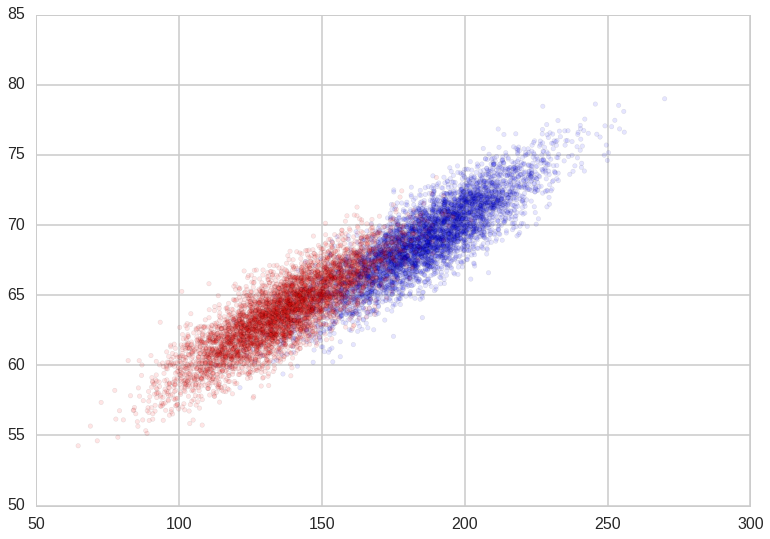

In [194]:
plt.scatter(dflog.Weight,dflog.Height, c=[cm_bright.colors[i] for i in dflog.Gender=='Male'], alpha=0.1)

In [195]:
dflog.values[:,1:].shape

(10000, 2)

In [196]:
# compute score using Kfold
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf,X,Y,score_func=accuracy_score):
    n_fold=5
    score =0
    for train,test in KFold(X.shape[0],5):
        clf.fit(X[train],Y[train])
        score += score_func(clf.predict(X[test]),Y[test])
    return score/n_fold

In [197]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

X,Y = dflog.values[:,1:],(dflog.Gender=='Male').values


Cs = [0.001, 0.1, 1, 10, 100]
best_c = 0
best_score =0

Xtrain,Xtest,ytrain,ytest = train_test_split(X,Y)

for c in Cs:
    clf = LogisticRegression(C=c)
    score = cv_score(clf,Xtrain, ytrain)
    if score>best_score:
        best_score = score
        best_c = c
print best_c,best_score
        

0.1 0.9176


In [198]:
clf = LogisticRegression(C=best_c)
clf.fit(Xtrain,ytrain)
print accuracy_score(clf.predict(Xtest),ytest)


0.9236


## with GridSearch

In [199]:
from sklearn.grid_search import GridSearchCV

cld = LogisticRegression()
parameters = {"C" : [0.001, 0.1, 1, 10, 100]}
fit_model = GridSearchCV(clf,param_grid = parameters,cv=5)
fit_model.fit(Xtrain,ytrain)

fit_model.best_estimator_


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [200]:
fit_model.grid_scores_

[mean: 0.91733, std: 0.00739, params: {'C': 0.001},
 mean: 0.91787, std: 0.00741, params: {'C': 0.1},
 mean: 0.91787, std: 0.00741, params: {'C': 1},
 mean: 0.91787, std: 0.00741, params: {'C': 10},
 mean: 0.91787, std: 0.00741, params: {'C': 100}]

## The ATM Camera example

In [201]:
data=np.load("data/imag.pix.npy")
y=np.load("data/imag.lbl.npy")
STANDARD_SIZE = (322, 137)#standardized pixels in image.
data.shape, y.shape

((87, 132342), (87,))

In [202]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((STANDARD_SIZE[1],STANDARD_SIZE[0], 3), 'uint8')#3 channels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

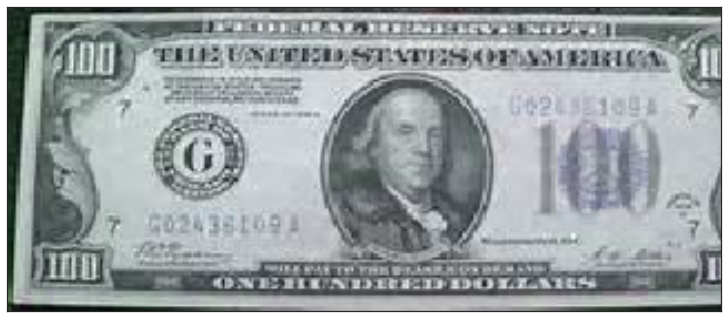

In [219]:
display_image(data[78,:])

In [222]:
pd.DataFrame(data).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,132292,132293,132294,132295,132296,132297,132298,132299,132300,132301,132302,132303,132304,132305,132306,132307,132308,132309,132310,132311,132312,132313,132314,132315,132316,132317,132318,132319,132320,132321,132322,132323,132324,132325,132326,132327,132328,132329,132330,132331,132332,132333,132334,132335,132336,132337,132338,132339,132340,132341
0,238,238,238,238,238,238,255,255,255,255,255,255,255,255,255,253,253,253,255,255,255,255,255,255,255,255,255,251,251,251,251,251,251,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,251,251,251,255,255,255,255,255,255,253,253,253,238,238,238
1,140,150,152,161,171,173,171,181,183,213,223,225,244,254,255,235,245,247,236,246,248,237,247,249,240,250,252,240,250,252,240,250,252,240,250,252,240,250,252,240,250,252,240,250,252,240,250,252,240,250,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
2,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,253,253,253,253,253,253,254,254,254,254,254,254,254,254,254,254,254,254,255,255,255,255,255,255
3,254,255,251,254,255,251,252,254,249,254,255,253,254,255,253,247,249,246,247,249,246,254,255,255,254,255,255,247,248,250,247,248,252,247,248,252,247,248,252,247,248,253,247,248,253,247,247,255,247,247,...,251,255,246,251,255,246,251,255,246,251,255,246,251,255,246,251,255,246,251,255,246,251,255,246,251,255,246,251,255,246,251,255,246,251,255,246,251,255,246,251,255,246,251,255,246,251,255,246,251,255
4,255,255,223,225,219,183,255,251,212,234,219,176,237,220,176,252,235,192,219,203,167,156,147,116,122,118,93,145,148,129,126,130,116,124,128,114,139,141,127,134,131,114,135,128,109,138,127,107,132,129,...,133,104,137,133,104,136,132,103,118,114,85,130,126,97,125,121,92,127,123,94,145,141,112,141,137,108,131,127,98,143,139,110,216,198,174,255,244,205,234,225,168,236,231,163,255,254,189,216,215,169


In [204]:
##with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
X = pca.fit_transform(data)

df_pca = pd.DataFrame(X)

df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,-22536.362571,2428.343967,2133.777242,-328.322450,1065.239885,-79.779510,425.028862,-622.482412,2490.207981,858.586365,-1072.565326,277.135956,-1117.008245,712.921050,-787.542306,414.930152,-195.835369,472.439595,-429.687952,609.645649,-588.997035,-266.805059,987.770869,-953.085804,1037.093164,-568.689960,-42.940841,-112.654017,520.389800,545.386992,-643.325633,-77.820997,-733.674370,1263.879103,586.756998,119.593373,-508.370089,-294.174840,-252.519347,-51.538313,-457.830940,758.886057,515.916103,440.076107,-463.097417,-225.847169,-72.615736,-280.709429,-588.030969,-448.784198,539.070474,173.421252,379.865134,160.692953,157.257050,450.314126,-227.221397,-112.364944,-186.038429,-68.330989
1,-22226.658684,709.255778,288.826225,-1300.635376,792.084752,-217.442930,-1076.777444,2115.106737,875.462523,1124.846524,-343.234147,-43.368372,547.937212,357.548885,-1761.499582,-372.120164,813.766003,293.993188,-941.050102,-154.191592,-1122.863363,507.700410,815.875978,-717.999469,289.149370,115.870070,816.665466,1144.817760,359.342436,120.101878,-851.744626,-582.296067,316.394094,176.118549,673.219112,657.451216,94.661336,192.333834,-142.834165,376.042041,120.771967,20.335283,697.047946,-22.197777,-299.883777,22.574739,-26.094463,-290.112096,1147.013054,318.365764,426.590209,-81.492381,218.911740,-293.833368,-574.800385,461.005213,-133.873301,86.549876,-68.253606,194.165434
2,-17364.260784,4252.027148,-793.802239,-1362.054543,374.230509,-3142.098137,-2514.239438,-1443.845989,121.012593,419.751003,-2083.156756,1717.655662,-723.242074,-1240.426110,-310.766668,-1059.408079,1385.595045,-799.959051,-2598.756819,880.676052,3384.434883,-389.628097,3414.296511,-1340.080791,-4755.217740,-1036.255043,2198.383527,-687.340263,-1379.299146,-2148.507251,-644.565929,-1683.784601,1774.957382,-3132.874465,861.445428,-2247.593057,3105.529724,-3040.391807,843.107937,-277.652726,1718.531906,-3134.639051,3721.305222,-1470.315986,-997.252433,665.795034,-629.128117,1304.004522,-113.079572,-2860.852264,2535.136052,-1801.134606,1147.956100,1897.679487,1262.972669,2524.590385,621.040293,-422.350399,-1367.147366,-822.139175
3,-22847.256199,900.591903,-577.203148,-180.315540,733.144739,107.929873,-1441.787045,1069.822194,-844.816567,1390.008267,1470.750252,-723.940456,-578.786597,-259.303433,932.522873,170.963935,-301.561034,871.589461,-180.217083,-1238.130123,557.669686,-174.747087,332.949651,370.770361,-934.637134,-180.894557,1318.174882,92.860081,273.711601,-464.485412,-167.088608,70.342765,101.594998,834.492608,195.240356,-635.616322,-394.941809,-336.312866,130.697946,352.956334,1431.120380,-790.615542,-977.419373,-580.005826,-414.524329,-520.226448,-706.248906,327.599586,-888.099678,-1645.789093,-91.398011,0.090413,66.658666,353.418805,82.527303,-737.466496,-662.261573,-535.062574,537.059324,-528.666270
4,-15868.672595,-3259.491423,-506.800796,-919.635265,-2166.553649,981.628130,1669.697325,391.328228,-1735.708244,-163.565703,-1626.848455,-556.071285,-863.023076,1721.533650,944.390131,-1133.831269,2139.645031,766.969676,-1093.378106,-602.035479,-28.726067,83.689740,505.980050,-1106.373987,332.008248,1227.814307,-708.139610,-713.030110,142.707832,-912.989078,1012.271645,3623.483860,2107.208639,-3363.795948,966.429469,2141.451996,-1849.211068,-2139.553978,2546.960143,472.873126,135.062864,1404.581160,1283.016300,1311.779794,269.914003,-960.813470,322.601451,-850.742712,3154.415688,1425.425648,946.439659,-2233.105652,109.845355,213.800180,-3525.269984,-2516.479764,722.617389,-1742.192699,-2282.672192,1720.499388


In [205]:
print inspect.getsource(PCA._fit)

    def _fit(self, X):
        """Fit the model on X

        Parameters
        ----------
        X: array-like, shape (n_samples, n_features)
            Training vector, where n_samples in the number of samples and
            n_features is the number of features.

        Returns
        -------
        U, s, V : ndarrays
            The SVD of the input data, copied and centered when
            requested.
        """
        X = check_array(X)
        n_samples, n_features = X.shape
        X = as_float_array(X, copy=self.copy)
        # Center data
        self.mean_ = np.mean(X, axis=0)
        X -= self.mean_
        U, S, V = linalg.svd(X, full_matrices=False)
        explained_variance_ = (S ** 2) / n_samples
        explained_variance_ratio_ = (explained_variance_ /
                                     explained_variance_.sum())

        components_ = V

        n_components = self.n_components
        if n_components is None:
            n_components = n_features
        

In [206]:
U, S, V = pca._fit(data)

pd.DataFrame(U*S).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
0,-22536.362571,2428.343967,2133.777242,-328.322450,1065.239885,-79.779510,425.028862,-622.482412,2490.207981,858.586365,-1072.565326,277.135956,-1117.008245,712.921050,-787.542306,414.930152,-195.835369,472.439595,-429.687952,609.645649,-588.997035,-266.805059,987.770869,-953.085804,1037.093164,-568.689960,-42.940841,-112.654017,520.389800,545.386992,-643.325633,-77.820997,-733.674370,1263.879103,586.756998,119.593373,-508.370089,-294.174840,-252.519347,-51.538313,-457.830940,758.886057,515.916103,440.076107,-463.097417,-225.847169,-72.615736,-280.709429,-588.030969,-448.784198,539.070474,173.421252,379.865134,160.692953,157.257050,450.314126,-227.221397,-112.364944,-186.038429,-68.330989,-526.977114,-650.633242,489.006162,519.332851,1862.861326,-957.844543,-427.382596,-392.879628,-264.024441,4.542386,688.680969,17.342327,150.322144,45.046328,467.043763,-92.554481,-1214.310894,555.047551,145.600696,1047.241718,-658.129461,1656.402571,-5242.274751,2060.673558,-423.979901,879.442462,2.798356e-11
1,-22226.658684,709.255778,288.826225,-1300.635376,792.084752,-217.442930,-1076.777444,2115.106737,875.462523,1124.846524,-343.234147,-43.368372,547.937212,357.548885,-1761.499582,-372.120164,813.766003,293.993188,-941.050102,-154.191592,-1122.863363,507.700410,815.875978,-717.999469,289.149370,115.870070,816.665466,1144.817760,359.342436,120.101878,-851.744626,-582.296067,316.394094,176.118549,673.219112,657.451216,94.661336,192.333834,-142.834165,376.042041,120.771967,20.335283,697.047946,-22.197777,-299.883777,22.574739,-26.094463,-290.112096,1147.013054,318.365764,426.590209,-81.492381,218.911740,-293.833368,-574.800385,461.005213,-133.873301,86.549876,-68.253606,194.165434,-259.501085,-233.936025,639.608365,585.898048,1569.549552,-519.544638,-508.027298,99.936539,-441.421658,-555.035230,1281.612696,-119.274536,-786.428396,171.357282,-504.369185,-382.096751,-981.655862,376.550690,-77.606247,2338.998374,-515.837300,3115.901003,542.014566,-4583.073099,-941.527211,578.841802,2.798356e-11
2,-17364.260784,4252.027148,-793.802239,-1362.054543,374.230509,-3142.098137,-2514.239438,-1443.845989,121.012593,419.751003,-2083.156756,1717.655662,-723.242074,-1240.426110,-310.766668,-1059.408079,1385.595045,-799.959051,-2598.756819,880.676052,3384.434883,-389.628097,3414.296511,-1340.080791,-4755.217740,-1036.255043,2198.383527,-687.340263,-1379.299146,-2148.507251,-644.565929,-1683.784601,1774.957382,-3132.874465,861.445428,-2247.593057,3105.529724,-3040.391807,843.107937,-277.652726,1718.531906,-3134.639051,3721.305222,-1470.315986,-997.252433,665.795034,-629.128117,1304.004522,-113.079572,-2860.852264,2535.136052,-1801.134606,1147.956100,1897.679487,1262.972669,2524.590385,621.040293,-422.350399,-1367.147366,-822.139175,1388.086043,214.025144,-1487.851886,804.615318,-22.964893,2045.409479,-171.253977,-140.584968,-782.277274,-127.765000,-137.598728,283.807912,-684.809697,-1002.330119,576.078612,-613.185414,-552.559992,-572.623297,-168.445388,-60.205249,480.877583,-315.147257,185.175504,345.396732,-69.600134,73.016130,2.798356e-11
3,-22847.256199,900.591903,-577.203148,-180.315540,733.144739,107.929873,-1441.787045,1069.822194,-844.816567,1390.008267,1470.750252,-723.940456,-578.786597,-259.303433,932.522873,170.963935,-301.561034,871.589461,-180.217083,-1238.130123,557.669686,-174.747087,332.949651,370.770361,-934.637134,-180.894557,1318.174882,92.860081,273.711601,-464.485412,-167.088608,70.342765,101.594998,834.492608,195.240356,-635.616322,-394.941809,-336.312866,130.697946,352.956334,1431.120380,-790.615542,-977.419373,-580.005826,-414.524329,-520.226448,-706.248906,327.599586,-888.099678,-1645.789093,-91.398011,0.090413,66.658666,353.418805,82.527303,-737.466496,-662.261573,-535.062574,537.059

<h1 ><font color='red'>SVD WORKS LIKE PCA ONLY IF YOU NORMALIZE THE DATA BEFORE !!!! (PCA does it automatically)</font></h1> 

In [207]:
## with svd
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import as_float_array
data_centered = as_float_array(data)

# Center data
mean = np.mean(data_centered, axis=0)
data_centered -= mean


U,S,V = np.linalg.svd(data_centered,full_matrices=False)

pd.DataFrame(U[:,:60] *S[:60]).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,-22536.362571,2428.343967,2133.777242,-328.322450,1065.239885,-79.779510,425.028862,-622.482412,2490.207981,858.586365,-1072.565326,277.135956,-1117.008245,712.921050,-787.542306,414.930152,-195.835369,472.439595,-429.687952,609.645649,-588.997035,-266.805059,987.770869,-953.085804,1037.093164,-568.689960,-42.940841,-112.654017,520.389800,545.386992,-643.325633,-77.820997,-733.674370,1263.879103,586.756998,119.593373,-508.370089,-294.174840,-252.519347,-51.538313,-457.830940,758.886057,515.916103,440.076107,-463.097417,-225.847169,-72.615736,-280.709429,-588.030969,-448.784198,539.070474,173.421252,379.865134,160.692953,157.257050,450.314126,-227.221397,-112.364944,-186.038429,-68.330989
1,-22226.658684,709.255778,288.826225,-1300.635376,792.084752,-217.442930,-1076.777444,2115.106737,875.462523,1124.846524,-343.234147,-43.368372,547.937212,357.548885,-1761.499582,-372.120164,813.766003,293.993188,-941.050102,-154.191592,-1122.863363,507.700410,815.875978,-717.999469,289.149370,115.870070,816.665466,1144.817760,359.342436,120.101878,-851.744626,-582.296067,316.394094,176.118549,673.219112,657.451216,94.661336,192.333834,-142.834165,376.042041,120.771967,20.335283,697.047946,-22.197777,-299.883777,22.574739,-26.094463,-290.112096,1147.013054,318.365764,426.590209,-81.492381,218.911740,-293.833368,-574.800385,461.005213,-133.873301,86.549876,-68.253606,194.165434
2,-17364.260784,4252.027148,-793.802239,-1362.054543,374.230509,-3142.098137,-2514.239438,-1443.845989,121.012593,419.751003,-2083.156756,1717.655662,-723.242074,-1240.426110,-310.766668,-1059.408079,1385.595045,-799.959051,-2598.756819,880.676052,3384.434883,-389.628097,3414.296511,-1340.080791,-4755.217740,-1036.255043,2198.383527,-687.340263,-1379.299146,-2148.507251,-644.565929,-1683.784601,1774.957382,-3132.874465,861.445428,-2247.593057,3105.529724,-3040.391807,843.107937,-277.652726,1718.531906,-3134.639051,3721.305222,-1470.315986,-997.252433,665.795034,-629.128117,1304.004522,-113.079572,-2860.852264,2535.136052,-1801.134606,1147.956100,1897.679487,1262.972669,2524.590385,621.040293,-422.350399,-1367.147366,-822.139175
3,-22847.256199,900.591903,-577.203148,-180.315540,733.144739,107.929873,-1441.787045,1069.822194,-844.816567,1390.008267,1470.750252,-723.940456,-578.786597,-259.303433,932.522873,170.963935,-301.561034,871.589461,-180.217083,-1238.130123,557.669686,-174.747087,332.949651,370.770361,-934.637134,-180.894557,1318.174882,92.860081,273.711601,-464.485412,-167.088608,70.342765,101.594998,834.492608,195.240356,-635.616322,-394.941809,-336.312866,130.697946,352.956334,1431.120380,-790.615542,-977.419373,-580.005826,-414.524329,-520.226448,-706.248906,327.599586,-888.099678,-1645.789093,-91.398011,0.090413,66.658666,353.418805,82.527303,-737.466496,-662.261573,-535.062574,537.059324,-528.666270
4,-15868.672595,-3259.491423,-506.800796,-919.635265,-2166.553649,981.628130,1669.697325,391.328228,-1735.708244,-163.565703,-1626.848455,-556.071285,-863.023076,1721.533650,944.390131,-1133.831269,2139.645031,766.969676,-1093.378106,-602.035479,-28.726067,83.689740,505.980050,-1106.373987,332.008248,1227.814307,-708.139610,-713.030110,142.707832,-912.989078,1012.271645,3623.483860,2107.208639,-3363.795948,966.429469,2141.451996,-1849.211068,-2139.553978,2546.960143,472.873126,135.062864,1404.581160,1283.016300,1311.779794,269.914003,-960.813470,322.601451,-850.742712,3154.415688,1425.425648,946.439659,-2233.105652,109.845355,213.800180,-3525.269984,-2516.479764,722.617389,-1742.192699,-2282.672192,1720.499388


In [216]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=322*137*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

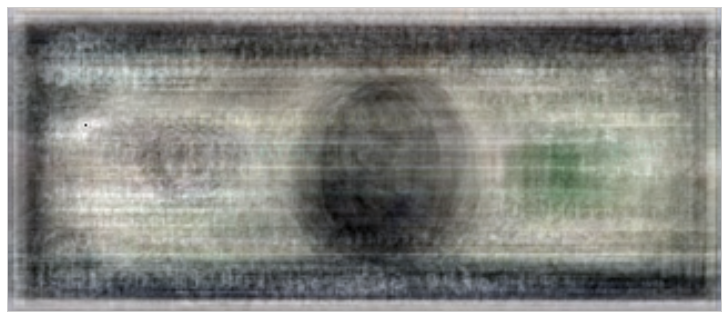

In [218]:
display_component(pca,0)

In [210]:
pd.DataFrame(pca.components_[0]).head()

,0
0,-0.001379
1,-0.001641
2,-0.001886
3,-0.001170
4,-0.001447


In [211]:
size=322*137*3
pd.DataFrame(V[0][0:size:3]).head()

,0
0,-0.001379
1,-0.001170
2,-0.001124
3,-0.000967
4,-0.001011


In [212]:
pd.DataFrame(V[0][1:size:3]).head()

,0
0,-0.001641
1,-0.001447
2,-0.001410
3,-0.001267
4,-0.001306


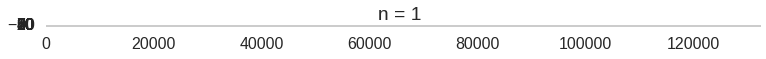

In [213]:
i=1
reconstimg = np.matrix(U[:, :i]) * np.diag(S[:i]) * np.matrix(V[:i, :])
plt.imshow(reconstimg, cmap='gray')
title = "n = %s " % i
plt.title(title)
plt.show()